# Imports

In [1]:
from pathlib import Path
from typing import Any, Callable, Optional

import numpy as np
from PIL import Image,  ImageOps
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader 
from torchvision import transforms
import torch
import cv2

In [2]:
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_to_dataset = '/content/drive/MyDrive/datasets/masks'

In [5]:
path_to_exp = '/content/drive/MyDrive/Froth/froth_dataset/exp'

# Preparing dataset

In [6]:
!mkdir /content/drive/MyDrive/Froth/froth_dataset/exp

mkdir: cannot create directory ‘/content/drive/MyDrive/Froth/froth_dataset/exp’: No such file or directory


In [7]:
#cp -r drive/MyDrive/Froth/masks drive/MyDrive/Froth/DeepLabv3/

In [8]:
#mv drive/MyDrive/Froth/DeepLabv3/masks drive/MyDrive/Froth/DeepLabv3/source_masks

In [9]:
#mv drive/MyDrive/Froth/DeepLabv3/source_masks/label/16*.png drive/MyDrive/Froth/DeepLabv3/source_masks/test_ds/label

In [10]:
def preprocess_mask(mask):
  mask = mask.astype(np.float32)/255
  return mask

In [11]:
"""
Author: Manpreet Singh Minhas
Contact: msminhas at uwaterloo ca
"""



class SegmentationDataset(VisionDataset):
    """A PyTorch dataset for image segmentation task.
    The dataset is compatible with torchvision transforms.
    The transforms passed would be applied to both the Images and Masks.
    """
    def __init__(self,
                 root: str,
                 image_folder: str,
                 mask_folder: str,
                 transforms: Optional[Callable] = None,
                 fraction: float = None,
                 subset: str = None,
                 image_color_mode: str = "rgb",
                 mask_color_mode: str = "grayscale") -> None:
        """
        Args:
            root (str): Root directory path.
            image_folder (str): Name of the folder that contains the images in the root directory.
            mask_folder (str): Name of the folder that contains the masks in the root directory.
            transforms (Optional[Callable], optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.ToTensor`` for images. Defaults to None.
            seed (int, optional): Specify a seed for the train and test split for reproducible results. Defaults to None.
            fraction (float, optional): A float value from 0 to 1 which specifies the validation split fraction. Defaults to None.
            subset (str, optional): 'Train' or 'Test' to select the appropriate set. Defaults to None.
            image_color_mode (str, optional): 'rgb' or 'grayscale'. Defaults to 'rgb'.
            mask_color_mode (str, optional): 'rgb' or 'grayscale'. Defaults to 'grayscale'.
        Raises:
            OSError: If image folder doesn't exist in root.
            OSError: If mask folder doesn't exist in root.
            ValueError: If subset is not either 'Train' or 'Test'
            ValueError: If image_color_mode and mask_color_mode are either 'rgb' or 'grayscale'
        """
        super().__init__(root, transforms)
        image_folder_path = Path(self.root) / image_folder
        mask_folder_path = Path(self.root) / mask_folder

        if not image_folder_path.exists():
            raise OSError(f"{image_folder_path} does not exist.")
        if not mask_folder_path.exists():
            raise OSError(f"{mask_folder_path} does not exist.")

        if not fraction:
            self.image_names = sorted(image_folder_path.glob("*"))
            self.mask_names = sorted(mask_folder_path.glob("*"))
        else:
            if subset not in ["Train", "Test"]:
                raise (ValueError(
                    f"{subset} is not a valid input. Acceptable values are Train and Test."
                ))
            self.fraction = fraction
            self.image_list = np.array(sorted(image_folder_path.glob("*")))
            self.mask_list = np.array(sorted(mask_folder_path.glob("*")))
            if subset == "Train":
                self.image_names = self.image_list[:int(
                    np.ceil(len(self.image_list) * (1 - self.fraction)))]
                self.mask_names = self.mask_list[:int(
                    np.ceil(len(self.mask_list) * (1 - self.fraction)))]
            else:
                self.image_names = self.image_list[
                    int(np.ceil(len(self.image_list) * (1 - self.fraction))):]
                self.mask_names = self.mask_list[
                    int(np.ceil(len(self.mask_list) * (1 - self.fraction))):]


    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, index: int) -> Any:
        image_path = str(self.image_names[index])
        mask_path = str(self.mask_names[index])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mask = cv2.imread(mask_path,  cv2.IMREAD_UNCHANGED)
        mask = np.expand_dims(mask, axis = 2)
        mask = preprocess_mask(mask)
        sample = {"image": image, "mask": mask}

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            sample["image"] = transformed["image"]
            sample["mask"] = transformed["mask"]
        return sample


In [12]:

def get_dataloader_single_folder(data_dir: str,
                                 image_folder: str = 'Images',
                                 mask_folder: str = 'Masks',
                                 fraction: float = 0.2,
                                 batch_size: int = 8):
    """Create train and test dataloader from a single directory containing
    the image and mask folders.
    Args:
        data_dir (str): Data directory path or root
        image_folder (str, optional): Image folder name. Defaults to 'Images'.
        mask_folder (str, optional): Mask folder name. Defaults to 'Masks'.
        fraction (float, optional): Fraction of Test set. Defaults to 0.2.
        batch_size (int, optional): Dataloader batch size. Defaults to 4.
    Returns:
        dataloaders: Returns dataloaders dictionary containing the
        Train and Test dataloaders.
    """
    # data_transforms = transforms.Compose([transforms.RandomCrop(size=(256, 256)), transforms.ToTensor()])
    # data_transforms = transforms.Compose([
    #                                       transforms.Resize(size=(256, 256)), 
    #                                       transforms.Grayscale(num_output_channels=1),
    #                                       transforms.ToTensor(),
    #                                       ])
    data_transforms = A.Compose([
                      A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                      A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
                      A.RandomCrop(500, 500),
                      A.Rotate(limit=45, p=0.5),
                      A.Resize(256, 256),
                      A.ToFloat(),
                      ToTensorV2(transpose_mask=True)])

    image_datasets = {
        x: SegmentationDataset(data_dir,
                               image_folder=image_folder,
                               mask_folder=mask_folder,
                               fraction=fraction,
                               subset=x,
                               transforms=data_transforms)
        for x in ['Train', 'Test']
    }
    dataloaders = {
        x: DataLoader(image_datasets[x],
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=2)
        for x in ['Train', 'Test']
    }
    return dataloaders

# W&B init

In [13]:
pip install wandb > /dev/null

In [14]:
# Flexible integration for any Python script
import wandb

In [15]:
def update_wb(model_name, lr, loss, th, opt):
  wandb.init(project="froth", entity="s70c3")
  wandb.run.name = f'{model_name}_lr{str(lr)}_loss_{loss}_th_{th}_opt_{opt}'
  # 2. Save model inputs and hyperparameters
  config = wandb.config
  config.learning_rate = lr
  config.epoch = 50
  config.batch_size=8
  config.name = model_name


# Metrics

In [16]:
SMOOTH = 1e-6

In [17]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch
    
    

In [18]:
def iou(outputs: np.array, labels: np.array):
    intersection = (outputs & labels).sum()
    union = (outputs | labels).sum()
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return iou # Or thresholded.mean()

# Training

In [19]:
#PyTorch
class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [20]:
#PyTorch

import cv2
def border1(p):
    p_dilate = cv2.dilate(p, np.ones((3, 3), np.uint8), iterations=1)
    border = (p != p_dilate).astype(np.uint8) 
    return border

import torch.nn.functional as F
def border2(p):
    averaged_mask = F.avg_pool2d(p.float(), (11, 11),
                                     stride=(1, 1),
                                     padding=(5, 5))
    border = ((averaged_mask > 0.01) * (averaged_mask < 0.99)).float()
    return border

class BoundaryWeightedLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(BoundaryWeightedLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        boundaries = border2(targets)
        inputs_boundaries = inputs * boundaries

        loss = torch.nn.BCELoss()

        loss_main = loss(inputs, targets)
        loss_b = loss(inputs_boundaries, boundaries)
        
        return loss_main * 0.3 + loss_b * 0.7

In [21]:
import copy
import csv
import os
import time

import numpy as np
import torch
from tqdm import tqdm

def train_model(model, criterion, dataloaders, optimizer, metrics, bpath,
                num_epochs, needs_out=False, threshold=0.5, scheduler=None):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Initialize the log file for training and testing loss and metrics
    fieldnames = ['epoch', 'Train_loss', 'Test_loss', '_timestamp', '_runtime'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Test_{m}' for m in metrics.keys()]
    with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        # Initialize batch summary
        batchsummary = {a: [0] for a in fieldnames}

        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            # Iterate over data.
            for sample in tqdm(iter(dataloaders[phase])):
                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
               
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)
                    y_pred = outputs.data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            # Use a classification threshold of 0.3
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > threshold))
                        elif name == 'iou':
                          batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > threshold))
                        else:
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true.astype('uint8'), y_pred))

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
            if scheduler is not None:
              scheduler.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            # print('{} Loss: {:.4f}'.format(phase, loss))
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        
        wandb.log(batchsummary)
        with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            print(batchsummary)
            writer.writerow(batchsummary)
            # deep copy the model
            if phase == 'Test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Ready to train & eval

In [22]:
def main(data_directory, exp_directory, epochs, batch_size, model, model_name, lr=1e-4, needs_out=False, threshold=0.5):
    # Create the deeplabv3 resnet101 model which is pretrained on a subset
    # of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.
    
    model.train()
    
    data_directory = Path(data_directory)
    # Create the experiment directory if not present
    exp_directory = Path(exp_directory)
    if not exp_directory.exists():
        exp_directory.mkdir()

    # Specify the loss function
    criterion = torch.nn.BCELoss()
    # criterion_borders = torch.nn.BCELoss(0.6)
    # criterion = BoundaryWeightedLoss()
    # criterion = DiceLoss()
    # criterion = torch.nn.CrossEntropyLoss()
    
    # Specify the optimizer with a lower learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//5, lr/10)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


    # Specify the evaluation metrics
    metrics = {'f1_score': f1_score, 'iou': jaccard_score}

    # Create the dataloader
    dataloaders = get_dataloader_single_folder(
        data_directory, 'image', 'label', batch_size=batch_size)
    
    samples = next(iter(dataloaders['Train']))
# Display the image and mask tensor shape
# We see the tensor size is correct bxcxhxw, where b is batch size, c is number of channels, h is height, w is width
    wandb.watch(model)
    _ = train_model(model,
                      criterion,
                      dataloaders,
                      optimizer,
                      bpath=exp_directory,
                      metrics=metrics,
                      num_epochs=epochs, 
                      needs_out=needs_out,
                      threshold=threshold,
                      scheduler = scheduler
                    )

      # Save the trained model
    torch.save(model, exp_directory / f'{model_name}_weights.pt')

# Models

In [23]:
import torch
from sklearn.metrics import f1_score, roc_auc_score, jaccard_score
from torch.utils import data
import time


## AttUnet

In [24]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch


class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x


class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x
        
class Attention_block(nn.Module):
    """
    Attention Block
    """

    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class AttU_Net(nn.Module):
    """
    Attention Unet implementation
    Paper: https://arxiv.org/abs/1804.03999
    """
    def __init__(self, img_ch=3, output_ch=1):
        super(AttU_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

        self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        #print(x5.shape)
        d5 = self.Up5(e5)
        #print(d5.shape)
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        out = self.active(out)

        return out

In [25]:
def createUnetAtt():
    model = AttU_Net(img_ch=1)
    model.train()
    return model

In [26]:
attunet = createUnetAtt()

## TransUnet

In [27]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 1.9 MB/s eta 0:00:00


In [28]:
import torch
import torch.nn as nn
import numpy as np
from einops import rearrange, repeat


class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, head_num):
        super().__init__()

        self.head_num = head_num
        self.dk = (embedding_dim // head_num) ** (1 / 2)

        self.qkv_layer = nn.Linear(embedding_dim, embedding_dim * 3, bias=False)
        self.out_attention = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, x, mask=None):
        qkv = self.qkv_layer(x)

        query, key, value = tuple(rearrange(qkv, 'b t (d k h ) -> k b h t d ', k=3, h=self.head_num))
        energy = torch.einsum("... i d , ... j d -> ... i j", query, key) * self.dk

        if mask is not None:
            energy = energy.masked_fill(mask, -np.inf)

        attention = torch.softmax(energy, dim=-1)

        x = torch.einsum("... i j , ... j d -> ... i d", attention, value)

        x = rearrange(x, "b h t d -> b t (h d)")
        x = self.out_attention(x)

        return x


class MLP(nn.Module):
    def __init__(self, embedding_dim, mlp_dim):
        super().__init__()

        self.mlp_layers = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(mlp_dim, embedding_dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        x = self.mlp_layers(x)

        return x


class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim, head_num, mlp_dim):
        super().__init__()

        self.multi_head_attention = MultiHeadAttention(embedding_dim, head_num)
        self.mlp = MLP(embedding_dim, mlp_dim)

        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        _x = self.multi_head_attention(x)
        _x = self.dropout(_x)
        x = x + _x
        x = self.layer_norm1(x)

        _x = self.mlp(x)
        x = x + _x
        x = self.layer_norm2(x)

        return x


class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, head_num, mlp_dim, block_num=12):
        super().__init__()

        self.layer_blocks = nn.ModuleList(
            [TransformerEncoderBlock(embedding_dim, head_num, mlp_dim) for _ in range(block_num)])

    def forward(self, x):
        for layer_block in self.layer_blocks:
            x = layer_block(x)

        return x


class ViT(nn.Module):
    def __init__(self, img_dim, in_channels, embedding_dim, head_num, mlp_dim,
                 block_num, patch_dim, classification=True, num_classes=1):
        super().__init__()

        self.patch_dim = patch_dim
        self.classification = classification
        self.num_tokens = (img_dim // patch_dim) ** 2
        self.token_dim = in_channels * (patch_dim ** 2)

        self.projection = nn.Linear(self.token_dim, embedding_dim)
        self.embedding = nn.Parameter(torch.rand(self.num_tokens + 1, embedding_dim))

        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        self.dropout = nn.Dropout(0.1)

        self.transformer = TransformerEncoder(embedding_dim, head_num, mlp_dim, block_num)

        if self.classification:
            self.mlp_head = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        img_patches = rearrange(x,
                                'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)',
                                patch_x=self.patch_dim, patch_y=self.patch_dim)

        batch_size, tokens, _ = img_patches.shape

        project = self.projection(img_patches)
        token = repeat(self.cls_token, 'b ... -> (b batch_size) ...',
                       batch_size=batch_size)

        patches = torch.cat([token, project], dim=1)
        patches += self.embedding[:tokens + 1, :]

        x = self.dropout(patches)
        x = self.transformer(x)
        x = self.mlp_head(x[:, 0, :]) if self.classification else x[:, 1:, :]

        return x


import torch
import torch.nn as nn
from einops import rearrange


class EncoderBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, base_width=64):
        super().__init__()

        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        width = int(out_channels * (base_width / 64))

        self.conv1 = nn.Conv2d(in_channels, width, kernel_size=1, stride=1, bias=False)
        self.norm1 = nn.BatchNorm2d(width)

        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=2, groups=1, padding=1, dilation=1, bias=False)
        self.norm2 = nn.BatchNorm2d(width)
        # self.conv2 = nn.Conv2d(out_channels * 8, out_channels * 4, kernel_size=3, stride=1, padding=1)
        # self.norm2 = nn.BatchNorm2d(out_channels * 4)   

        self.conv3 = nn.Conv2d(width, out_channels, kernel_size=1, stride=1, bias=False)
        self.norm3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x_down = self.downsample(x)

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = x + x_down
        x = self.relu(x)

        return x


class DecoderBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=True)
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, x_concat=None):
        x = self.upsample(x)

        if x_concat is not None:
            x = torch.cat([x_concat, x], dim=1)

        x = self.layer(x)
        return x

class EncoderTrans(nn.Module):
      def __init__(self, img_dim, in_channels, out_channels, head_num, mlp_dim, block_num, patch_dim):
          super().__init__()

          self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=2, padding=3, bias=False)
          self.norm1 = nn.BatchNorm2d(out_channels)
          self.relu = nn.ReLU(inplace=True)

          self.encoder1 = EncoderBottleneck(out_channels, out_channels * 2, stride=2)
          self.encoder2 = EncoderBottleneck(out_channels * 2, out_channels * 4, stride=2)
          self.encoder3 = EncoderBottleneck(out_channels * 4, out_channels * 8, stride=2)

          self.vit_img_dim = img_dim // patch_dim
          self.vit = ViT(self.vit_img_dim, out_channels * 8, out_channels * 8,
                        head_num, mlp_dim, block_num, patch_dim=1, classification=False)

          self.conv2 = nn.Conv2d(out_channels * 8, 512, kernel_size=3, stride=1, padding=1)
          self.norm2 = nn.BatchNorm2d(512)

      def forward(self, x):
          x = self.conv1(x)
          x = self.norm1(x)
          x1 = self.relu(x)

          x2 = self.encoder1(x1)
          x3 = self.encoder2(x2)
          x = self.encoder3(x3)

          x = self.vit(x)
          x = rearrange(x, "b (x y) c -> b c x y", x=self.vit_img_dim, y=self.vit_img_dim)

          x = self.conv2(x)
          x = self.norm2(x)
          x = self.relu(x)

          return x, x1, x2, x3


class DecoderTrans(nn.Module):
    def __init__(self, out_channels, class_num):
        super().__init__()

        self.decoder1 = DecoderBottleneck(out_channels * 8, out_channels * 2)
        self.decoder2 = DecoderBottleneck(out_channels * 4, out_channels)
        self.decoder3 = DecoderBottleneck(out_channels * 2, int(out_channels * 1 / 2))
        self.decoder4 = DecoderBottleneck(int(out_channels * 1 / 2), int(out_channels * 1 / 8))

        self.conv1 = nn.Conv2d(int(out_channels * 1 / 8), class_num, kernel_size=1)

        self.active = torch.nn.Sigmoid()

    def forward(self, x, x1, x2, x3):
        x = self.decoder1(x, x3)
        x = self.decoder2(x, x2)
        x = self.decoder3(x, x1)
        x = self.decoder4(x)
        x = self.conv1(x)
        x = self.active(x)

        return x

class TransUNet(nn.Module):
    def __init__(self, img_dim, in_channels, out_channels, head_num, mlp_dim, block_num, patch_dim, class_num):
        super().__init__()

        self.encoder = EncoderTrans(img_dim, in_channels, out_channels,
                                    head_num, mlp_dim, block_num, patch_dim)

        self.decoder = DecoderTrans(out_channels, class_num)

    def forward(self, x):
        x, x1, x2, x3 = self.encoder(x)
        x = self.decoder(x, x1, x2, x3)

        return x

    


if __name__ == '__main__':
    import torch

    transunet = TransUNet(img_dim=128,
                          in_channels=3,
                          out_channels=128,
                          head_num=4,
                          mlp_dim=512,
                          block_num=8,
                          patch_dim=16,
                          class_num=1)

    print(sum(p.numel() for p in transunet.parameters()))
    print(transunet(torch.randn(1, 3, 128, 128)).shape)

66882673
torch.Size([1, 1, 128, 128])


In [29]:
def createTransUnet():
    # model = TransUNet(img_dim=512,
    #                     in_channels=3,
    #                     out_channels=128,
    #                     head_num=4,
    #                     mlp_dim=512,
    #                     block_num=8,
    #                     patch_dim=16,
    #                     class_num=1)
    model = TransUNet(img_dim=256,
                    in_channels=1,
                    out_channels=128,
                    head_num=4,
                    mlp_dim=512,
                    block_num=8,
                    patch_dim=16,
                    class_num=1)
    model.train()
    return model

In [30]:
#https://github.com/mkara44/transunet_pytorch/tree/929e07b35a9769a7deffc42031322fe722545190

## DS-TransUnet

In [31]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


class CrossAttention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_k = nn.Linear(dim, inner_dim, bias=False)
        self.to_v = nn.Linear(dim, inner_dim, bias=False)
        self.to_q = nn.Linear(dim, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x_qkv):
        b, n, _, h = *x_qkv.shape, self.heads

        k = self.to_k(x_qkv)
        k = rearrange(k, 'b n (h d) -> b h n d', h=h)

        v = self.to_v(x_qkv)
        v = rearrange(v, 'b n (h d) -> b h n d', h=h)

        q = self.to_q(x_qkv[:, 0].unsqueeze(1))
        q = rearrange(q, 'b n (h d) -> b h n d', h=h)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
import numpy as np
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from torch.autograd import Variable

# from utils.checkpoint import load_checkpoint
# from mmseg.utils import get_root_logger

# from utils.module import Attention, PreNorm, FeedForward, CrossAttention

groups = 32


class Mlp(nn.Module):
    """ Multilayer perceptron."""

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features).cuda()
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features).cuda()
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    """ Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """ Forward function.
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class SwinTransformerBlock(nn.Module):
    """ Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        self.H = None
        self.W = None

    def forward(self, x, mask_matrix):
        """ Forward function.
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
            mask_matrix: Attention mask for cyclic shift.
        """
        B, L, C = x.shape
        H, W = self.H, self.W
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # pad feature maps to multiples of window size
        pad_l = pad_t = 0
        pad_r = (self.window_size - W % self.window_size) % self.window_size
        pad_b = (self.window_size - H % self.window_size) % self.window_size
        x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
        _, Hp, Wp, _ = x.shape

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
            attn_mask = mask_matrix
        else:
            shifted_x = x
            attn_mask = None

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, Hp, Wp)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        if pad_r > 0 or pad_b > 0:
            x = x[:, :H, :W, :].contiguous()

        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class PatchRecover(nn.Module):
    """ Patch Merging Layer
    Args:
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(dim, dim // 2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.GroupNorm(num_channels=dim // 2, num_groups=groups),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, H, W):
        """ Forward function.
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
        """
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.permute(0, 1, 2)  # B ,C, L
        x = x.reshape(B, C, H, W)
        x = self.up(x)  # B, C//2, H, W

        x = x.reshape(B, C // 2, -1)
        x = x.permute(0, 2, 1)

        # x = Variable(torch.randn(B, H * 2, W * 2, C // 2))

        return x


class PatchMerging(nn.Module):
    """ Patch Merging Layer
    Args:
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x, H, W):
        """ Forward function.
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
        """
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)

        # padding
        pad_input = (H % 2 == 1) or (W % 2 == 1)
        if pad_input:
            x = F.pad(x, (0, 0, 0, W % 2, 0, H % 2))

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of feature channels
        depth (int): Depths of this stage.
        num_heads (int): Number of attention head.
        window_size (int): Local window size. Default: 7.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self,
                 dim,
                 depth,
                 num_heads,
                 window_size=7,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.,
                 norm_layer=nn.LayerNorm,
                 downsample=None,
                 use_checkpoint=False,
                 up=True):
        super().__init__()
        self.window_size = window_size
        self.shift_size = window_size // 2
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        self.up = up

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(
                dim=dim,
                num_heads=num_heads,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop,
                attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, H, W):
        """ Forward function.
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
        """

        # calculate attention mask for SW-MSA
        Hp = int(np.ceil(H / self.window_size)) * self.window_size
        Wp = int(np.ceil(W / self.window_size)) * self.window_size
        img_mask = torch.zeros((1, Hp, Wp, 1), device=x.device)  # 1 Hp Wp 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        for blk in self.blocks:
            blk.H, blk.W = H, W
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, attn_mask)
            else:
                x = blk(x, attn_mask)
        if self.downsample is not None:
            x_down = self.downsample(x, H, W)
            if self.up:
                Wh, Ww = (H + 1) // 2, (W + 1) // 2
            else:
                Wh, Ww = H * 2, W * 2
            return x, H, W, x_down, Wh, Ww
        else:
            return x, H, W, x, H, W


class PatchEmbed(nn.Module):

    def __init__(self, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        self.patch_size = patch_size

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        """Forward function."""
        # padding
        _, _, H, W = x.size()
        if W % self.patch_size[1] != 0:
            x = F.pad(x, (0, self.patch_size[1] - W % self.patch_size[1]))
        if H % self.patch_size[0] != 0:
            x = F.pad(x, (0, 0, 0, self.patch_size[0] - H % self.patch_size[0]))

        x = self.proj(x)  # B C Wh Ww
        if self.norm is not None:
            Wh, Ww = x.size(2), x.size(3)
            x = x.flatten(2).transpose(1, 2)
            x = self.norm(x)
            x = x.transpose(1, 2).view(-1, self.embed_dim, Wh, Ww)

        return x


class MultiEmbed(nn.Module):

    def __init__(self, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        self.patch_size = patch_size

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=1)
        self.bn = nn.BatchNorm2d(embed_dim)
        self.maxPool = nn.MaxPool2d(kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        """Forward function."""
        # padding
        _, _, H, W = x.size()
        if W % self.patch_size[1] != 0:
            x = F.pad(x, (0, self.patch_size[1] - W % self.patch_size[1]))
        if H % self.patch_size[0] != 0:
            x = F.pad(x, (0, 0, 0, self.patch_size[0] - H % self.patch_size[0]))

        x = self.proj(x)  # B C Wh Ww
        x = self.bn(x)
        x = self.maxPool(x)
        if self.norm is not None:
            Wh, Ww = x.size(2), x.size(3)
            x = x.flatten(2).transpose(1, 2)
            x = self.norm(x)
            x = x.transpose(1, 2).view(-1, self.embed_dim, Wh, Ww)

        return x


class SwinTransformer(nn.Module):
    """ Swin Transformer backbone.
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030
    Args:
        pretrain_img_size (int): Input image size for training the pretrained model,
            used in absolute postion embedding. Default 224.
        patch_size (int | tuple(int)): Patch size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        depths (tuple[int]): Depths of each Swin Transformer stage.
        num_heads (tuple[int]): Number of attention head of each stage.
        window_size (int): Window size. Default: 7.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4.
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set.
        drop_rate (float): Dropout rate.
        attn_drop_rate (float): Attention dropout rate. Default: 0.
        drop_path_rate (float): Stochastic depth rate. Default: 0.2.
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False.
        patch_norm (bool): If True, add normalization after patch embedding. Default: True.
        out_indices (Sequence[int]): Output from which stages.
        frozen_stages (int): Stages to be frozen (stop grad and set eval mode).
            -1 means not freezing any parameters.
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self,
                 pretrain_img_size=224,
                 patch_size=4,
                 in_chans=3,
                 embed_dim=128,
                 depths=[2, 2, 18, 2],
                 num_heads=[4, 8, 16, 32],
                 window_size=7,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.5,
                 norm_layer=nn.LayerNorm,
                 ape=False,
                 patch_norm=True,
                 out_indices=(0, 1, 2, 3),
                 frozen_stages=-1,
                 use_checkpoint=False):
        super().__init__()

        self.pretrain_img_size = pretrain_img_size
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.out_indices = out_indices
        self.frozen_stages = frozen_stages

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            pretrain_img_size = to_2tuple(pretrain_img_size)
            patch_size = to_2tuple(patch_size)
            patches_resolution = [pretrain_img_size[0] // patch_size[0], pretrain_img_size[1] // patch_size[1]]

            self.absolute_pos_embed = nn.Parameter(
                torch.zeros(1, embed_dim, patches_resolution[0], patches_resolution[1]))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2 ** i_layer),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                use_checkpoint=use_checkpoint)
            self.layers.append(layer)

        num_features = [int(embed_dim * 2 ** i) for i in range(self.num_layers)]
        self.num_features = num_features

        # add a norm layer for each output
        for i_layer in out_indices:
            layer = norm_layer(num_features[i_layer])
            layer_name = f'norm{i_layer}'
            self.add_module(layer_name, layer)

        self._freeze_stages()

    def _freeze_stages(self):
        if self.frozen_stages >= 0:
            self.patch_embed.eval()
            for param in self.patch_embed.parameters():
                param.requires_grad = False

        if self.frozen_stages >= 1 and self.ape:
            self.absolute_pos_embed.requires_grad = False

        if self.frozen_stages >= 2:
            self.pos_drop.eval()
            for i in range(0, self.frozen_stages - 1):
                m = self.layers[i]
                m.eval()
                for param in m.parameters():
                    param.requires_grad = False

    def init_weights(self, pretrained=None):
        """Initialize the weights in backbone.
        Args:
            pretrained (str, optional): Path to pre-trained weights.
                Defaults to None.
        """

        def _init_weights(m):
            if isinstance(m, nn.Linear):
                trunc_normal_(m.weight, std=.02)
                if isinstance(m, nn.Linear) and m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)

            # if isinstance(pretrained, str):
            #     self.apply(_init_weights)
            #     logger = get_root_logger()
            #     load_checkpoint(self, pretrained, strict=False, logger=logger)
            # elif pretrained is None:
            self.apply(_init_weights)
        # else:
        # raise TypeError('pretrained must be a str or None')

    def forward(self, x):
        """Forward function."""
        x = self.patch_embed(x)

        Wh, Ww = x.size(2), x.size(3)
        if self.ape:
            # interpolate the position embedding to the corresponding size
            absolute_pos_embed = F.interpolate(self.absolute_pos_embed, size=(Wh, Ww), mode='bicubic')
            x = (x + absolute_pos_embed).flatten(2).transpose(1, 2)  # B Wh*Ww C
        else:
            x = x.flatten(2).transpose(1, 2)
        x = self.pos_drop(x)

        outs = []
        for i in range(self.num_layers):
            layer = self.layers[i]
            x_out, H, W, x, Wh, Ww = layer(x, Wh, Ww)

            if i in self.out_indices:
                norm_layer = getattr(self, f'norm{i}')
                x_out = norm_layer(x_out)

                out = x_out.view(-1, H, W, self.num_features[i]).permute(0, 3, 1, 2).contiguous()
                outs.append(out)

        return outs

    def train(self, mode=True):
        """Convert the model into training mode while keep layers freezed."""
        super(SwinTransformer, self).train(mode)
        self._freeze_stages()


class up_conv(nn.Module):
    """
    Up Convolution Block
    """

    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.GroupNorm(num_channels=out_ch, num_groups=groups),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class conv_block_ds(nn.Module):
    """
    Convolution Block
    """

    def __init__(self, in_ch, out_ch):
        super(conv_block_ds, self).__init__()
        self.conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.GroupNorm(num_channels=out_ch, num_groups=groups),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.GroupNorm(num_channels=out_ch, num_groups=groups),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x


class Conv_block(nn.Module):
    """
    Convolution Block
    """

    def __init__(self, in_ch, out_ch):
        super(Conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.GroupNorm(num_channels=out_ch, num_groups=groups),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.GroupNorm(num_channels=out_ch, num_groups=groups),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x


class SwinUp(nn.Module):
    def __init__(self, dim):
        super(SwinUp, self).__init__()
        self.up = nn.Linear(dim, dim * 2).cuda()
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, H, W):
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = self.norm(x)
        x = self.up(x)
        x = x.reshape(B, H, W, 2 * C)

        x0 = x[:, :, :, 0:C // 2]
        x1 = x[:, :, :, C // 2:C]
        x2 = x[:, :, :, C:C + C // 2]
        x3 = x[:, :, :, C + C // 2:C * 2]

        x0 = torch.cat((x0, x1), dim=1)
        x3 = torch.cat((x2, x3), dim=1)
        x = torch.cat((x0, x3), dim=2)

        # x = Variable(torch.randn(B, H * 2, W * 2, C // 2))

        x = x.reshape(B, -1, C // 2)
        return x


class SwinDecoder(nn.Module):

    def __init__(self,
                 embed_dim,
                 patch_size=4,
                 depths=2,
                 num_heads=6,
                 window_size=7,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.2,
                 norm_layer=nn.LayerNorm,
                 patch_norm=True,
                 use_checkpoint=False):
        super(SwinDecoder, self).__init__()

        self.patch_norm = patch_norm

        # split image into non-overlapping patches

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depths)]  # stochastic depth decay rule

        # build layers
        self.layer = BasicLayer(
            dim=embed_dim // 2,
            depth=depths,
            num_heads=num_heads,
            window_size=window_size,
            mlp_ratio=mlp_ratio,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            drop=drop_rate,
            attn_drop=attn_drop_rate,
            drop_path=dpr,
            norm_layer=norm_layer,
            downsample=None,
            use_checkpoint=use_checkpoint)

        self.up = up_conv(embed_dim, embed_dim // 2)
        self.conv_relu = nn.Sequential(
            nn.Conv2d(embed_dim // 2, embed_dim // 4, kernel_size=1, stride=1, padding=0),
            nn.ReLU()
        )

    def forward(self, x):
        """Forward function."""

        # print(x.shape)
        # for i in range(len(e_o)):
        #    layer = self.layers[i]
        #    x_out, H, W, x, Wh, Ww = layer(x, Wh, Ww)
        # return x

        identity = x
        B, C, H, W = x.shape
        x = self.up(x)  # B , C//2, 2H, 2W
        x = x.reshape(B, C // 2, H * W * 4)
        x = x.permute(0, 2, 1)

        x_out, H, W, x, Wh, Ww = self.layer(x, H * 2, W * 2)

        x = x.permute(0, 2, 1)
        x = x.reshape(B, C // 2, H, W)
        # B, C//4 2H, 2W
        x = self.conv_relu(x)

        return x

class Decoder(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.up = up_conv(in_channels, out_channels)
        # self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_relu = nn.Sequential(
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            # coorAtt(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # x2 = self.att_block(x1, x2)
        x1 = torch.cat((x2, x1), dim=1)
        x1 = self.conv_relu(x1)
        return x1


class Swin_Decoder(nn.Module):
    def __init__(self, in_channels, depths, num_heads):
        super(Swin_Decoder, self).__init__()
        self.up = SwinDecoder(in_channels, depths=depths, num_heads=num_heads)
        # self.up1 = nn.Upsample(scale_factor=2)
        # self.up2 = nn.Conv2d(in_channels, in_channels//2, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv_relu = nn.Sequential(
            nn.Conv2d(in_channels // 2, in_channels // 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels // 2, in_channels // 4, kernel_size=1, stride=1, padding=0),
            nn.ReLU()
        )

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # x1 = self.up2(x1)
        # x2 = self.att_block(x1, x2)
        x2 = self.conv2(x2)
        x1 = torch.cat((x2, x1), dim=1)
        out = self.conv_relu(x1)
        return out


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class Cross_Att(nn.Module):
    def __init__(self, dim_s, dim_l):
        super().__init__()
        self.transformer_s = Transformer(dim=dim_s, depth=1, heads=3, dim_head=32, mlp_dim=128)
        self.transformer_l = Transformer(dim=dim_l, depth=1, heads=1, dim_head=64, mlp_dim=256)
        self.norm_s = nn.LayerNorm(dim_s)
        self.norm_l = nn.LayerNorm(dim_l)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.linear_s = nn.Linear(dim_s, dim_l)
        self.linear_l = nn.Linear(dim_l, dim_s)

    def forward(self, e, r):
        b_e, c_e, h_e, w_e = e.shape
        e = e.reshape(b_e, c_e, -1).permute(0, 2, 1)
        b_r, c_r, h_r, w_r = r.shape
        r = r.reshape(b_r, c_r, -1).permute(0, 2, 1)
        e_t = torch.flatten(self.avgpool(self.norm_l(e).transpose(1, 2)), 1)
        r_t = torch.flatten(self.avgpool(self.norm_s(r).transpose(1, 2)), 1)
        e_t = self.linear_l(e_t).unsqueeze(1)
        r_t = self.linear_s(r_t).unsqueeze(1)
        r = self.transformer_s(torch.cat([e_t, r], dim=1))[:, 1:, :]
        e = self.transformer_l(torch.cat([r_t, e], dim=1))[:, 1:, :]
        e = e.permute(0, 2, 1).reshape(b_e, c_e, h_e, w_e)
        r = r.permute(0, 2, 1).reshape(b_r, c_r, h_r, w_r)
        return e, r


class DSTransUNet(nn.Module):
    def __init__(self, dim, n_class, in_ch=1):
        super().__init__()
        self.encoder = SwinTransformer(depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32], drop_path_rate=0.5,
                                       embed_dim=128, in_chans=1)
        self.encoder2 = SwinTransformer(depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24], drop_path_rate=0.2, patch_size=8,
                                        embed_dim=96, in_chans=1)
        self.encoder.init_weights('checkpoints/swin_base_patch4_window7_224_22k.pth')
        self.encoder2.init_weights('checkpoints/swin_tiny_patch4_window7_224.pth')
        self.layer1 = Swin_Decoder(8 * dim, 2, 8)
        self.layer2 = Swin_Decoder(4 * dim, 2, 4)
        self.layer3 = Swin_Decoder(2 * dim, 2, 2)
        self.layer4 = Decoder(dim, dim, dim // 2)
        self.layer5 = Decoder(dim // 2, dim // 2, dim // 4)
        self.down1 = nn.Conv2d(in_ch, dim // 4, kernel_size=1, stride=1, padding=0)
        self.down2 = conv_block_ds(dim // 4, dim // 2)
        self.final = nn.Conv2d(dim // 4, n_class, kernel_size=1, stride=1, padding=0)

        self.loss1 = nn.Sequential(
            nn.Conv2d(dim * 8, n_class, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.Upsample(scale_factor=32)
        )

        self.loss2 = nn.Sequential(
            nn.Conv2d(dim, n_class, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.Upsample(scale_factor=4)
        )
        dim_s = 96
        dim_l = 128
        self.m1 = nn.Upsample(scale_factor=2)
        self.m2 = nn.Upsample(scale_factor=4)
        tb = dim_s + dim_l
        self.change1 = Conv_block(tb, dim)
        self.change2 = Conv_block(tb * 2, dim * 2)
        self.change3 = Conv_block(tb * 4, dim * 4)
        self.change4 = Conv_block(tb * 8, dim * 8)
        self.cross_att_1 = Cross_Att(dim_s * 1, dim_l * 1)
        self.cross_att_2 = Cross_Att(dim_s * 2, dim_l * 2)
        self.cross_att_3 = Cross_Att(dim_s * 4, dim_l * 4)
        self.cross_att_4 = Cross_Att(dim_s * 8, dim_l * 8)
        self.active = torch.nn.Sigmoid()

    def forward(self, x):
        out = self.encoder(x)
        out2 = self.encoder2(x)
        e1, e2, e3, e4 = out[0], out[1], out[2], out[3]
        r1, r2, r3, r4 = out2[0], out2[1], out2[2], out2[3]
        e1, r1 = self.cross_att_1(e1, r1)
        e2, r2 = self.cross_att_2(e2, r2)
        e3, r3 = self.cross_att_3(e3, r3)
        e4, r4 = self.cross_att_4(e4, r4)
        e1 = torch.cat([e1, self.m1(r1)], 1)
        e2 = torch.cat([e2, self.m1(r2)], 1)
        e3 = torch.cat([e3, self.m1(r3)], 1)
        e4 = torch.cat([e4, self.m1(r4)], 1)
        e1 = self.change1(e1)
        e2 = self.change2(e2)
        e3 = self.change3(e3)
        e4 = self.change4(e4)
        loss1 = self.loss1(e4)
        ds1 = self.down1(x)
        ds2 = self.down2(ds1)
        d1 = self.layer1(e4, e3)
        d2 = self.layer2(d1, e2)
        d3 = self.layer3(d2, e1)
        loss2 = self.loss2(d3)
        d4 = self.layer4(d3, ds2)
        d5 = self.layer5(d4, ds1)
        o = self.final(d5)
        o = self.active(o)

        return o



In [33]:
def createDSTransUnet():
  model = DSTransUNet(256, 1, 1).cuda()
  model.train()
  return model

## Unet

In [30]:
def createUnet(inputchannels=1, outputchannels=1):
  model = smp.Unet(
      # encoder_name="resnet152",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
      # encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
      in_channels=inputchannels,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
      activation = 'sigmoid',
      classes=outputchannels,                      # model output channels (number of classes in your dataset)
  )
  model.train()
  return model

## Unet++

In [31]:
pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 23.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16445 sha256=9e354cf24e0020481c87e663bb02352f705dd18c11d04da7552f1d7c8618cba9
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60963 sha256=5175c8a35adeb941c4706e92a57fbff878475f8a5f807a56c5eef05032b56648
  Stored in directory: /root/.cache/pip/w

In [32]:
import segmentation_models_pytorch as smp

In [33]:
def createUnetPlusPlus(inputchannels=1, outputchannels=1):
  model = smp.UnetPlusPlus(#'resnet152',
                          #  encoder_weights="imagenet", 
                           in_channels=inputchannels, 
                           activation = 'sigmoid',
                           classes=1)
  model.train()
  return model

In [38]:
unetplusplus = createUnetPlusPlus()

# Train

In [34]:
def createModel(model_name):
  needs_out = False
  if model_name=='unet':
    model = createUnet()
  elif model_name=='unetplusplus':
    model = createUnetPlusPlus()
  elif model_name=='attunet':
    model = createUnetAtt()
  elif model_name=='transunet':
    model = createTransUnet()
  elif model_name=='dstransunet':
    model = createDSTransUnet()
  else:
    raise ValueError('no such model')
  return model, needs_out

In [35]:
path_to_dataset = '/content/drive/MyDrive/datasets/masks'

In [40]:
model_names = [  
    'unet', 
    "unetplusplus", 
    'attunet', 
    'transunet', 
    # 'dstransunet'
    ]


In [37]:
ready = []

In [ ]:
lr = 1e-4
loss = 'WBCE'
th = 0.6
opt = "Adam"
for model_name in model_names:
  print(model_name)
  # training
  model, needs_out = createModel(model_name)
  update_wb(model_name=model_name, lr=lr, loss=loss, th=th, opt = opt)
  path_to_exp = f'/content/drive/MyDrive/Froth/exp_{loss}_{lr}_{opt}'

  main(path_to_dataset, path_to_exp, 100, 4, model, model_name, lr=lr, needs_out=needs_out, threshold=th)
  ready.append(model_name)

unet


Epoch 1/100
----------


100%|██████████| 15/15 [00:07<00:00,  1.97it/s]

{'epoch': 1, 'Train_loss': 0.5981523990631104, 'Test_loss': 0.5157356858253479, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.4653385932044741, 'Train_iou': 0.3132722899998805, 'Test_f1_score': 0.08869075572477406, 'Test_iou': 0.047327452505078756}
Epoch 2/100
----------



100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


{'epoch': 2, 'Train_loss': 0.45869171619415283, 'Test_loss': 0.4199395477771759, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.5890138312121334, 'Train_iou': 0.4250605914263587, 'Test_f1_score': 0.30997936380941704, 'Test_iou': 0.18700978735050255}
Epoch 3/100
----------


100%|██████████| 15/15 [00:03<00:00,  4.99it/s]

{'epoch': 3, 'Train_loss': 0.42718252539634705, 'Test_loss': 0.5080935955047607, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6269880569790931, 'Train_iou': 0.4656072859149368, 'Test_f1_score': 0.4128256065558358, 'Test_iou': 0.2657360539977724}
Epoch 4/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.88it/s]

{'epoch': 4, 'Train_loss': 0.39486774802207947, 'Test_loss': 0.44609010219573975, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6068046258510955, 'Train_iou': 0.4459206602655256, 'Test_f1_score': 0.3809124914636157, 'Test_iou': 0.24082463858048167}
Epoch 5/100
----------



100%|██████████| 15/15 [00:05<00:00,  3.00it/s]

{'epoch': 5, 'Train_loss': 0.7605531215667725, 'Test_loss': 0.46630099415779114, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6507528853182903, 'Train_iou': 0.4909013547238614, 'Test_f1_score': 0.27813603079457583, 'Test_iou': 0.16375613803816003}
Epoch 6/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.59it/s]

{'epoch': 6, 'Train_loss': 0.4294218420982361, 'Test_loss': 0.36368149518966675, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6587751597086238, 'Train_iou': 0.4993908875552004, 'Test_f1_score': 0.3896890964001757, 'Test_iou': 0.24991332308649733}
Epoch 7/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.61it/s]

{'epoch': 7, 'Train_loss': 0.3887675404548645, 'Test_loss': 0.42845767736434937, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.649887543920915, 'Train_iou': 0.49006344756720854, 'Test_f1_score': 0.44819460219506513, 'Test_iou': 0.2954785878838121}
Epoch 8/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.12it/s]

{'epoch': 8, 'Train_loss': 0.4523835778236389, 'Test_loss': 0.34485357999801636, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6686281280520998, 'Train_iou': 0.5099884559088386, 'Test_f1_score': 0.34413395941351377, 'Test_iou': 0.21303351039793111}
Epoch 9/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.95it/s]

{'epoch': 9, 'Train_loss': 0.39717933535575867, 'Test_loss': 0.34053993225097656, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6633531486751774, 'Train_iou': 0.5060436810406348, 'Test_f1_score': 0.410289658771602, 'Test_iou': 0.26346742324003863}
Epoch 10/100
----------



100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


{'epoch': 10, 'Train_loss': 0.5033212900161743, 'Test_loss': 0.33490651845932007, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6555770994076596, 'Train_iou': 0.49691642201586245, 'Test_f1_score': 0.44517781046237376, 'Test_iou': 0.2930226832731579}
Epoch 11/100
----------


100%|██████████| 15/15 [00:02<00:00,  5.08it/s]

{'epoch': 11, 'Train_loss': 0.4156985878944397, 'Test_loss': 0.3123571276664734, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6784846287473213, 'Train_iou': 0.521518957695606, 'Test_f1_score': 0.40514072053986844, 'Test_iou': 0.25982249967295445}
Epoch 12/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.93it/s]

{'epoch': 12, 'Train_loss': 0.3549879193305969, 'Test_loss': 0.3599524199962616, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6633939831631055, 'Train_iou': 0.5069156139292259, 'Test_f1_score': 0.42842720215068764, 'Test_iou': 0.27848544429656913}
Epoch 13/100
----------



100%|██████████| 15/15 [00:04<00:00,  3.34it/s]

{'epoch': 13, 'Train_loss': 0.3967006802558899, 'Test_loss': 0.4848361015319824, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6733601098612824, 'Train_iou': 0.515892463364708, 'Test_f1_score': 0.37973997307462476, 'Test_iou': 0.23897654528857873}
Epoch 14/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.06it/s]

{'epoch': 14, 'Train_loss': 0.40199393033981323, 'Test_loss': 0.28080523014068604, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6772893548916861, 'Train_iou': 0.5212131875853759, 'Test_f1_score': 0.39066491835796013, 'Test_iou': 0.24781367050259384}
Epoch 15/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.05it/s]

{'epoch': 15, 'Train_loss': 0.4151459336280823, 'Test_loss': 0.5222371816635132, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6678213413568428, 'Train_iou': 0.5118783178614471, 'Test_f1_score': 0.4257177336495675, 'Test_iou': 0.27623998719469}
Epoch 16/100
----------



100%|██████████| 15/15 [00:05<00:00,  2.97it/s]

{'epoch': 16, 'Train_loss': 0.44459038972854614, 'Test_loss': 0.31904470920562744, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6808475439471838, 'Train_iou': 0.5248257624034186, 'Test_f1_score': 0.3638760472761828, 'Test_iou': 0.22748600375133188}
Epoch 17/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.93it/s]

{'epoch': 17, 'Train_loss': 0.4430656433105469, 'Test_loss': 0.30007392168045044, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6887797218050379, 'Train_iou': 0.5355703612814151, 'Test_f1_score': 0.375271338681119, 'Test_iou': 0.23519936681583886}
Epoch 18/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.04it/s]

{'epoch': 18, 'Train_loss': 0.3473416268825531, 'Test_loss': 0.48036736249923706, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6838362866027832, 'Train_iou': 0.5298051524255242, 'Test_f1_score': 0.3374560218876168, 'Test_iou': 0.2069760865362541}
Epoch 19/100
----------



100%|██████████| 15/15 [00:04<00:00,  3.34it/s]

{'epoch': 19, 'Train_loss': 0.44389113783836365, 'Test_loss': 0.33094513416290283, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6942209014404107, 'Train_iou': 0.5414060540678575, 'Test_f1_score': 0.3946973947890744, 'Test_iou': 0.2508250648026945}
Epoch 20/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.93it/s]

{'epoch': 20, 'Train_loss': 0.39110785722732544, 'Test_loss': 0.41092783212661743, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6930411485640723, 'Train_iou': 0.5402236991706274, 'Test_f1_score': 0.3871857710177905, 'Test_iou': 0.2454707658294729}
Epoch 21/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.71it/s]

{'epoch': 21, 'Train_loss': 0.8541816473007202, 'Test_loss': 0.3752904534339905, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6939787883832855, 'Train_iou': 0.5418515812643144, 'Test_f1_score': 0.4559179129157199, 'Test_iou': 0.3019001776333796}
Epoch 22/100
----------



100%|██████████| 15/15 [00:03<00:00,  3.84it/s]

{'epoch': 22, 'Train_loss': 0.3419276177883148, 'Test_loss': 0.39135804772377014, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6966267947808872, 'Train_iou': 0.5457750598404147, 'Test_f1_score': 0.479593375841194, 'Test_iou': 0.3227189907942296}
Epoch 23/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.97it/s]

{'epoch': 23, 'Train_loss': 0.46991151571273804, 'Test_loss': 0.34883642196655273, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6825759682304577, 'Train_iou': 0.5318255893287925, 'Test_f1_score': 0.39013239357095564, 'Test_iou': 0.24725115886215893}
Epoch 24/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.29it/s]

{'epoch': 24, 'Train_loss': 0.3513984680175781, 'Test_loss': 0.38334161043167114, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6816730374961949, 'Train_iou': 0.5277916753322716, 'Test_f1_score': 0.3525029394097926, 'Test_iou': 0.21823858858673467}
Epoch 25/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.12it/s]

{'epoch': 25, 'Train_loss': 0.3281313180923462, 'Test_loss': 0.3336053490638733, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.6954953960381118, 'Train_iou': 0.5453656868985838, 'Test_f1_score': 0.4425165108130541, 'Test_iou': 0.2900893989267985}
Epoch 26/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.99it/s]

{'epoch': 26, 'Train_loss': 0.42334043979644775, 'Test_loss': 0.3198053240776062, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7106246215669484, 'Train_iou': 0.5601773555984204, 'Test_f1_score': 0.42805542451854317, 'Test_iou': 0.2785293580494911}
Epoch 27/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.22it/s]

{'epoch': 27, 'Train_loss': 0.3396521210670471, 'Test_loss': 0.35871371626853943, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7109939959856688, 'Train_iou': 0.5632925313501108, 'Test_f1_score': 0.4440566500972398, 'Test_iou': 0.29130281921286205}
Epoch 28/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.49it/s]

{'epoch': 28, 'Train_loss': 0.4282824397087097, 'Test_loss': 0.3196190297603607, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7128970228388278, 'Train_iou': 0.564430407667195, 'Test_f1_score': 0.46478902809869704, 'Test_iou': 0.3093612969659686}
Epoch 29/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.07it/s]

{'epoch': 29, 'Train_loss': 0.31660404801368713, 'Test_loss': 0.32120752334594727, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.720222840293022, 'Train_iou': 0.5739227042363966, 'Test_f1_score': 0.4994021512714455, 'Test_iou': 0.3412003989330854}
Epoch 30/100
----------



100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


{'epoch': 30, 'Train_loss': 0.3318140506744385, 'Test_loss': 0.28590863943099976, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.714344582105609, 'Train_iou': 0.566967407504705, 'Test_f1_score': 0.46040117151385035, 'Test_iou': 0.3058589118238442}
Epoch 31/100
----------


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]

{'epoch': 31, 'Train_loss': 0.41368889808654785, 'Test_loss': 0.2825976014137268, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7238355316443964, 'Train_iou': 0.5769208902365666, 'Test_f1_score': 0.44887540792231284, 'Test_iou': 0.29614944831523715}
Epoch 32/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.09it/s]

{'epoch': 32, 'Train_loss': 0.3792842626571655, 'Test_loss': 0.4603439271450043, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7228176633538164, 'Train_iou': 0.5765832975193925, 'Test_f1_score': 0.43917652441052, 'Test_iou': 0.28854867824630487}
Epoch 33/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


{'epoch': 33, 'Train_loss': 0.3272503614425659, 'Test_loss': 0.3033335208892822, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.724300289354947, 'Train_iou': 0.5777404393630411, 'Test_f1_score': 0.46411623898313675, 'Test_iou': 0.3093289504288739}
Epoch 34/100
----------


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]

{'epoch': 34, 'Train_loss': 0.322349488735199, 'Test_loss': 0.4148574471473694, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7201378986863434, 'Train_iou': 0.5739688510659118, 'Test_f1_score': 0.4717761925710526, 'Test_iou': 0.3156869753961478}
Epoch 35/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.18it/s]

{'epoch': 35, 'Train_loss': 0.42796576023101807, 'Test_loss': 0.3155513107776642, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7137280084179695, 'Train_iou': 0.5681484358539467, 'Test_f1_score': 0.4028022977318865, 'Test_iou': 0.25738771701998353}
Epoch 36/100
----------



100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


{'epoch': 36, 'Train_loss': 0.4727514684200287, 'Test_loss': 0.31229838728904724, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7181765815951935, 'Train_iou': 0.5719618385465304, 'Test_f1_score': 0.4525197068224193, 'Test_iou': 0.2984891650591288}
Epoch 37/100
----------


100%|██████████| 15/15 [00:03<00:00,  4.78it/s]

{'epoch': 37, 'Train_loss': 0.429513543844223, 'Test_loss': 0.35802948474884033, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7196824456321826, 'Train_iou': 0.5716657912249062, 'Test_f1_score': 0.4856118606872542, 'Test_iou': 0.3280505067797237}
Epoch 38/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.06it/s]

{'epoch': 38, 'Train_loss': 0.2989382743835449, 'Test_loss': 0.34471559524536133, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7057089196787745, 'Train_iou': 0.5596120655861894, 'Test_f1_score': 0.48814457100223285, 'Test_iou': 0.3310624560604718}
Epoch 39/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.04it/s]

{'epoch': 39, 'Train_loss': 0.41443943977355957, 'Test_loss': 0.22922322154045105, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7125452091852026, 'Train_iou': 0.5645403903481496, 'Test_f1_score': 0.518032025433325, 'Test_iou': 0.35822154238171655}
Epoch 40/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.64it/s]

{'epoch': 40, 'Train_loss': 0.48493561148643494, 'Test_loss': 0.30029258131980896, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7238957136639806, 'Train_iou': 0.5777557567547906, 'Test_f1_score': 0.47966547564397, 'Test_iou': 0.32302738419192795}
Epoch 41/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.02it/s]

{'epoch': 41, 'Train_loss': 0.45126304030418396, 'Test_loss': 0.2999228239059448, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7042607418415537, 'Train_iou': 0.5554977061686531, 'Test_f1_score': 0.46002103709514947, 'Test_iou': 0.3064403764222796}
Epoch 42/100
----------



100%|██████████| 15/15 [00:03<00:00,  3.81it/s]

{'epoch': 42, 'Train_loss': 0.3415888249874115, 'Test_loss': 0.3880702257156372, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7192968076256573, 'Train_iou': 0.5722819329449729, 'Test_f1_score': 0.5220356803231603, 'Test_iou': 0.3621308449232392}
Epoch 43/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.11it/s]

{'epoch': 43, 'Train_loss': 0.3368765115737915, 'Test_loss': 0.2813906669616699, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7196269183239782, 'Train_iou': 0.5720820166505233, 'Test_f1_score': 0.45896776863287303, 'Test_iou': 0.3054422866830604}
Epoch 44/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.05it/s]

{'epoch': 44, 'Train_loss': 0.33825406432151794, 'Test_loss': 0.3938106596469879, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7260675486344496, 'Train_iou': 0.5797454467584421, 'Test_f1_score': 0.48141535731861024, 'Test_iou': 0.3247502370182323}
Epoch 45/100
----------



100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


{'epoch': 45, 'Train_loss': 0.3666350543498993, 'Test_loss': 0.2780241072177887, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7110601971345921, 'Train_iou': 0.5647152106882446, 'Test_f1_score': 0.4238472300582491, 'Test_iou': 0.2743200336172119}
Epoch 46/100
----------


100%|██████████| 15/15 [00:03<00:00,  4.89it/s]

{'epoch': 46, 'Train_loss': 0.2863442897796631, 'Test_loss': 0.22709383070468903, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7296744294252078, 'Train_iou': 0.5865241118195543, 'Test_f1_score': 0.4947087627018426, 'Test_iou': 0.33629260838159714}
Epoch 47/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.05it/s]

{'epoch': 47, 'Train_loss': 0.4150635898113251, 'Test_loss': 0.18353472650051117, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7391279663103952, 'Train_iou': 0.597313022807794, 'Test_f1_score': 0.4853227331523823, 'Test_iou': 0.3282294342290386}
Epoch 48/100
----------



100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


{'epoch': 48, 'Train_loss': 0.3426697254180908, 'Test_loss': 0.3917504847049713, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7165130400142301, 'Train_iou': 0.5719407310675567, 'Test_f1_score': 0.46951913716662186, 'Test_iou': 0.31374967722864266}
Epoch 49/100
----------


100%|██████████| 15/15 [00:03<00:00,  4.82it/s]

{'epoch': 49, 'Train_loss': 0.33464106917381287, 'Test_loss': 0.3157843053340912, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.732368703250835, 'Train_iou': 0.5907726566878633, 'Test_f1_score': 0.48797228758577227, 'Test_iou': 0.33023877891874664}
Epoch 50/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.11it/s]

{'epoch': 50, 'Train_loss': 0.3135771155357361, 'Test_loss': 0.30330318212509155, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7317985449106803, 'Train_iou': 0.5898530846434401, 'Test_f1_score': 0.5017988309215301, 'Test_iou': 0.3432901193657638}
Epoch 51/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.03it/s]

{'epoch': 51, 'Train_loss': 0.3145005702972412, 'Test_loss': 0.23751160502433777, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7194676441699466, 'Train_iou': 0.5768161305525908, 'Test_f1_score': 0.4856472731201217, 'Test_iou': 0.3290107454121718}
Epoch 52/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.54it/s]

{'epoch': 52, 'Train_loss': 0.3343794345855713, 'Test_loss': 0.23991388082504272, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7430015419616018, 'Train_iou': 0.6017531634808986, 'Test_f1_score': 0.480099930779366, 'Test_iou': 0.3243234515844378}
Epoch 53/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.07it/s]

{'epoch': 53, 'Train_loss': 0.30654019117355347, 'Test_loss': 0.2569531202316284, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7331151920582788, 'Train_iou': 0.5930214206162578, 'Test_f1_score': 0.44924883098311735, 'Test_iou': 0.2977190148593224}
Epoch 54/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


{'epoch': 54, 'Train_loss': 0.5556394457817078, 'Test_loss': 0.36561521887779236, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.739021515520047, 'Train_iou': 0.5973790313752478, 'Test_f1_score': 0.4614877127597483, 'Test_iou': 0.30718075646963844}
Epoch 55/100
----------


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]

{'epoch': 55, 'Train_loss': 0.3258987367153168, 'Test_loss': 0.4062840938568115, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7324105052081462, 'Train_iou': 0.5893876622303957, 'Test_f1_score': 0.4664959662880398, 'Test_iou': 0.3111149162531385}
Epoch 56/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.06it/s]

{'epoch': 56, 'Train_loss': 0.35254788398742676, 'Test_loss': 0.3382236659526825, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7321701966203704, 'Train_iou': 0.5930262280795494, 'Test_f1_score': 0.5181188660298446, 'Test_iou': 0.3589586065112473}
Epoch 57/100
----------



100%|██████████| 15/15 [00:03<00:00,  3.99it/s]

{'epoch': 57, 'Train_loss': 0.30642467737197876, 'Test_loss': 0.39321911334991455, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7365153555871108, 'Train_iou': 0.5956807367263504, 'Test_f1_score': 0.493621327093277, 'Test_iou': 0.3353643523310976}
Epoch 58/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.33it/s]

{'epoch': 58, 'Train_loss': 0.29663562774658203, 'Test_loss': 0.3637908101081848, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7310005174817691, 'Train_iou': 0.5887742718661375, 'Test_f1_score': 0.46461833782122486, 'Test_iou': 0.31000790262209355}
Epoch 59/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.11it/s]

{'epoch': 59, 'Train_loss': 0.2751927673816681, 'Test_loss': 0.3688678443431854, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7086749291889948, 'Train_iou': 0.565134855695938, 'Test_f1_score': 0.3922576723124117, 'Test_iou': 0.24844148030143764}
Epoch 60/100
----------



100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


{'epoch': 60, 'Train_loss': 0.3154604732990265, 'Test_loss': 0.2760377526283264, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.726123984144544, 'Train_iou': 0.58348704812955, 'Test_f1_score': 0.4915003598104626, 'Test_iou': 0.33409533780604755}
Epoch 61/100
----------


100%|██████████| 15/15 [00:03<00:00,  4.82it/s]

{'epoch': 61, 'Train_loss': 0.33053717017173767, 'Test_loss': 0.3818323612213135, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7175461325154668, 'Train_iou': 0.5748060399554048, 'Test_f1_score': 0.39979614290337556, 'Test_iou': 0.2555898203218039}
Epoch 62/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.18it/s]

{'epoch': 62, 'Train_loss': 0.3444206714630127, 'Test_loss': 0.3389132618904114, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7271028748819952, 'Train_iou': 0.5826546443462493, 'Test_f1_score': 0.5125925980708576, 'Test_iou': 0.35404335064158077}
Epoch 63/100
----------



100%|██████████| 15/15 [00:04<00:00,  3.72it/s]

{'epoch': 63, 'Train_loss': 0.3341313302516937, 'Test_loss': 0.5669575333595276, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7250878758850335, 'Train_iou': 0.582756188401303, 'Test_f1_score': 0.5031321715468173, 'Test_iou': 0.3449347958909952}
Epoch 64/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.98it/s]

{'epoch': 64, 'Train_loss': 0.3633947968482971, 'Test_loss': 0.3467276692390442, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.740171832983903, 'Train_iou': 0.5996270951254102, 'Test_f1_score': 0.4670035415117756, 'Test_iou': 0.3115122805104069}
Epoch 65/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.93it/s]

{'epoch': 65, 'Train_loss': 0.35688039660453796, 'Test_loss': 0.27587753534317017, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7383731369907025, 'Train_iou': 0.5979738676165182, 'Test_f1_score': 0.51802642370572, 'Test_iou': 0.35936522420367145}
Epoch 66/100
----------



100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


{'epoch': 66, 'Train_loss': 0.29429638385772705, 'Test_loss': 0.32475364208221436, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7306274027039156, 'Train_iou': 0.5886393479742696, 'Test_f1_score': 0.5031573223601276, 'Test_iou': 0.34444178254001634}
Epoch 67/100
----------


100%|██████████| 15/15 [00:02<00:00,  5.06it/s]

{'epoch': 67, 'Train_loss': 0.32187163829803467, 'Test_loss': 0.24452440440654755, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7395679510663971, 'Train_iou': 0.6010265460590509, 'Test_f1_score': 0.5376737535430762, 'Test_iou': 0.3778500840989541}
Epoch 68/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.17it/s]

{'epoch': 68, 'Train_loss': 0.3229435682296753, 'Test_loss': 0.31537216901779175, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7436853151269327, 'Train_iou': 0.6046066627930317, 'Test_f1_score': 0.4953289038397589, 'Test_iou': 0.33743093542108005}
Epoch 69/100
----------



100%|██████████| 15/15 [00:04<00:00,  3.49it/s]

{'epoch': 69, 'Train_loss': 0.36368250846862793, 'Test_loss': 0.3495528995990753, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7330566002681025, 'Train_iou': 0.5920606659409219, 'Test_f1_score': 0.47857240945764223, 'Test_iou': 0.32195473893720294}
Epoch 70/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.20it/s]

{'epoch': 70, 'Train_loss': 0.2647794485092163, 'Test_loss': 0.20795714855194092, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7456797854040259, 'Train_iou': 0.6069411458171283, 'Test_f1_score': 0.49286032056912576, 'Test_iou': 0.33544166130766695}
Epoch 71/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.98it/s]

{'epoch': 71, 'Train_loss': 0.3880113959312439, 'Test_loss': 0.31148844957351685, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.743310599464888, 'Train_iou': 0.6046600475531562, 'Test_f1_score': 0.4971305507428063, 'Test_iou': 0.3393049632933874}
Epoch 72/100
----------



100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


{'epoch': 72, 'Train_loss': 0.3355632424354553, 'Test_loss': 0.2603710889816284, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.742507012121712, 'Train_iou': 0.6033320393645641, 'Test_f1_score': 0.5083552179862469, 'Test_iou': 0.34945040781095044}
Epoch 73/100
----------


100%|██████████| 15/15 [00:03<00:00,  4.80it/s]

{'epoch': 73, 'Train_loss': 0.30444151163101196, 'Test_loss': 0.31260350346565247, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.743708712676508, 'Train_iou': 0.605195555400182, 'Test_f1_score': 0.47118838247674644, 'Test_iou': 0.31564923403427814}
Epoch 74/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.99it/s]

{'epoch': 74, 'Train_loss': 0.29519036412239075, 'Test_loss': 0.2719866633415222, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.739776865029276, 'Train_iou': 0.6000066593145102, 'Test_f1_score': 0.5041920907733557, 'Test_iou': 0.3455815962914983}
Epoch 75/100
----------



100%|██████████| 15/15 [00:04<00:00,  3.23it/s]


{'epoch': 75, 'Train_loss': 0.46968400478363037, 'Test_loss': 0.1974378526210785, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7474085870557322, 'Train_iou': 0.6102384273160321, 'Test_f1_score': 0.4279560995675712, 'Test_iou': 0.2787810231716066}
Epoch 76/100
----------


100%|██████████| 15/15 [00:02<00:00,  5.06it/s]

{'epoch': 76, 'Train_loss': 0.29168981313705444, 'Test_loss': 0.3749954104423523, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7472655925150966, 'Train_iou': 0.6079092857759115, 'Test_f1_score': 0.5032087250316599, 'Test_iou': 0.34464400967075565}
Epoch 77/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.07it/s]

{'epoch': 77, 'Train_loss': 0.3574953079223633, 'Test_loss': 0.3314308524131775, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7443231930426196, 'Train_iou': 0.6077764868132336, 'Test_f1_score': 0.5216000931375481, 'Test_iou': 0.3619570923668298}
Epoch 78/100
----------



100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


{'epoch': 78, 'Train_loss': 0.4858248233795166, 'Test_loss': 0.4008399546146393, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7381712129718291, 'Train_iou': 0.5984507179876255, 'Test_f1_score': 0.46071828588261887, 'Test_iou': 0.30670450884052775}
Epoch 79/100
----------


100%|██████████| 15/15 [00:02<00:00,  5.04it/s]

{'epoch': 79, 'Train_loss': 0.3319718837738037, 'Test_loss': 0.30197229981422424, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.738551467819796, 'Train_iou': 0.5972141287944964, 'Test_f1_score': 0.46455538042693445, 'Test_iou': 0.30994604208000043}
Epoch 80/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.98it/s]

{'epoch': 80, 'Train_loss': 0.3200615346431732, 'Test_loss': 0.32077518105506897, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7397664079338003, 'Train_iou': 0.6004733845576229, 'Test_f1_score': 0.5176868399549053, 'Test_iou': 0.3578336794960129}
Epoch 81/100
----------



100%|██████████| 15/15 [00:04<00:00,  3.08it/s]

{'epoch': 81, 'Train_loss': 0.35544437170028687, 'Test_loss': 0.27915138006210327, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7268968748687028, 'Train_iou': 0.5858162633518038, 'Test_f1_score': 0.5240308543335671, 'Test_iou': 0.3647904851295322}
Epoch 82/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.99it/s]

{'epoch': 82, 'Train_loss': 0.2945172190666199, 'Test_loss': 0.42126965522766113, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7291527871888223, 'Train_iou': 0.588021065441828, 'Test_f1_score': 0.49834353070298926, 'Test_iou': 0.3401273717435686}
Epoch 83/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.03it/s]

{'epoch': 83, 'Train_loss': 0.3373468816280365, 'Test_loss': 0.3801368474960327, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7436617134426405, 'Train_iou': 0.6050287319072792, 'Test_f1_score': 0.4905497123673037, 'Test_iou': 0.33324068342148977}
Epoch 84/100
----------



100%|██████████| 15/15 [00:04<00:00,  3.48it/s]

{'epoch': 84, 'Train_loss': 0.35575008392333984, 'Test_loss': 0.3902934789657593, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7350224313986353, 'Train_iou': 0.5938250121647605, 'Test_f1_score': 0.5521568923750914, 'Test_iou': 0.391860060624056}
Epoch 85/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.99it/s]

{'epoch': 85, 'Train_loss': 0.2695695459842682, 'Test_loss': 0.3678858280181885, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.74948351845434, 'Train_iou': 0.6126694154673188, 'Test_f1_score': 0.4975828631472956, 'Test_iou': 0.3393853822149775}
Epoch 86/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


{'epoch': 86, 'Train_loss': 0.40577828884124756, 'Test_loss': 0.36082786321640015, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7539677177562749, 'Train_iou': 0.6166372770569319, 'Test_f1_score': 0.48770936456867037, 'Test_iou': 0.330852317577882}
Epoch 87/100
----------


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]

{'epoch': 87, 'Train_loss': 0.3388323485851288, 'Test_loss': 0.33874058723449707, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7571271754851425, 'Train_iou': 0.6222522807348942, 'Test_f1_score': 0.47766621049000874, 'Test_iou': 0.32121289076969856}
Epoch 88/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.90it/s]

{'epoch': 88, 'Train_loss': 0.32796913385391235, 'Test_loss': 0.2375689148902893, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7569422433902792, 'Train_iou': 0.6199792227032459, 'Test_f1_score': 0.5335921450681504, 'Test_iou': 0.373365363322574}
Epoch 89/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


{'epoch': 89, 'Train_loss': 0.277924507856369, 'Test_loss': 0.41999655961990356, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7500564639234609, 'Train_iou': 0.6139508313395945, 'Test_f1_score': 0.503391222910853, 'Test_iou': 0.34443958228697796}
Epoch 90/100
----------


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]

{'epoch': 90, 'Train_loss': 0.35021811723709106, 'Test_loss': 0.35263487696647644, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7615105544554717, 'Train_iou': 0.6273400430484388, 'Test_f1_score': 0.49416709555483174, 'Test_iou': 0.3361016507822628}
Epoch 91/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.94it/s]

{'epoch': 91, 'Train_loss': 0.3350376784801483, 'Test_loss': 0.27989834547042847, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7473504835712657, 'Train_iou': 0.6118347369815401, 'Test_f1_score': 0.5116777168993856, 'Test_iou': 0.35327514816390304}
Epoch 92/100
----------



100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


{'epoch': 92, 'Train_loss': 0.2885877788066864, 'Test_loss': 0.24618718028068542, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7484468463053778, 'Train_iou': 0.6119071271098457, 'Test_f1_score': 0.5167229461066352, 'Test_iou': 0.3573408936684357}
Epoch 93/100
----------


100%|██████████| 15/15 [00:03<00:00,  4.92it/s]

{'epoch': 93, 'Train_loss': 0.257568895816803, 'Test_loss': 0.27729332447052, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7595052634886688, 'Train_iou': 0.6244232013111298, 'Test_f1_score': 0.5219289986439947, 'Test_iou': 0.36200803353730415}
Epoch 94/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.99it/s]

{'epoch': 94, 'Train_loss': 0.3295762538909912, 'Test_loss': 0.3008264899253845, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7577289367839143, 'Train_iou': 0.6235840813196877, 'Test_f1_score': 0.5120679216913353, 'Test_iou': 0.3527581497198607}
Epoch 95/100
----------



100%|██████████| 15/15 [00:04<00:00,  3.12it/s]


{'epoch': 95, 'Train_loss': 0.3022303879261017, 'Test_loss': 0.36174285411834717, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7529886644123199, 'Train_iou': 0.6181438943467396, 'Test_f1_score': 0.5072570570475358, 'Test_iou': 0.34823328215298843}
Epoch 96/100
----------


100%|██████████| 15/15 [00:02<00:00,  5.10it/s]

{'epoch': 96, 'Train_loss': 0.3066423833370209, 'Test_loss': 0.31483930349349976, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7550873252480539, 'Train_iou': 0.6201402899744158, 'Test_f1_score': 0.5317015577080934, 'Test_iou': 0.3716312328126855}
Epoch 97/100
----------



100%|██████████| 15/15 [00:02<00:00,  5.04it/s]

{'epoch': 97, 'Train_loss': 0.2651354968547821, 'Test_loss': 0.26523280143737793, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7609278328030654, 'Train_iou': 0.6270779975184224, 'Test_f1_score': 0.5447740369049041, 'Test_iou': 0.38478233530404926}
Epoch 98/100
----------



100%|██████████| 15/15 [00:04<00:00,  3.06it/s]

{'epoch': 98, 'Train_loss': 0.3365088403224945, 'Test_loss': 0.3495471477508545, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7571379516045641, 'Train_iou': 0.6212656882260797, 'Test_f1_score': 0.505891277992835, 'Test_iou': 0.3478114844354925}
Epoch 99/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.99it/s]

{'epoch': 99, 'Train_loss': 0.35960492491722107, 'Test_loss': 0.21118392050266266, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7531503529675093, 'Train_iou': 0.6157428778560641, 'Test_f1_score': 0.5126951178463901, 'Test_iou': 0.35331402999815026}
Epoch 100/100
----------



100%|██████████| 15/15 [00:03<00:00,  4.98it/s]


{'epoch': 100, 'Train_loss': 0.28616565465927124, 'Test_loss': 0.29080507159233093, '_timestamp': 0.0, '_runtime': 0.0, 'Train_f1_score': 0.7496734097826175, 'Train_iou': 0.6144835366269635, 'Test_f1_score': 0.5411698485104105, 'Test_iou': 0.38119571929057855}
Training complete in 34m 49s
Lowest Loss: 0.183535
unetplusplus


# Compute & visualize

In [44]:
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [45]:
def prepare_data(img_number):
    image = Image.open(f'{path_to_dataset}/image/{img_number}.png').convert("L")
    w, h = image.size
    image = np.array(ImageOps.autocontrast(image, cutoff=3))
    # source = np.array(image.crop((0, 0, h, h)))
    resized_img = cv2.resize(image.copy(), (256, 256)).reshape(1, 1, 256, 256)

    target = cv2.imread(f'{path_to_dataset}/label/{img_number}.png')
    target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    h, w = target.shape
    # target = target[0:h, 0:h]
    resized_target = cv2.resize(target.copy()//255, (256, 256))
    return image, resized_img, target, resized_target

In [46]:
def compute_result(model, model_name, source, th=0.5):
    with torch.no_grad():
        a = model(torch.from_numpy(source).type(torch.cuda.FloatTensor)/255)
    if model_name=='deeplabv3':
      pred_raw= (a['out'].cpu().detach().numpy()[0][0]*255).astype(np.uint8)
      pred = (a['out'].cpu().detach().numpy()[0][0]>th).astype(np.uint8)
    else:
       pred_raw = (a.cpu().detach().numpy()[0][0]*255).astype(np.uint8)
       pred = (a.cpu().detach().numpy()[0][0]>th).astype(np.uint8)
    return pred_raw, pred

In [47]:
def visualize(source, target, pred_raw, pred, cont):
    plt.figure(figsize=(20,20));
    plt.subplot(141);
    plt.imshow(source, );
    plt.title('Image')
    plt.axis('off');
    plt.subplot(142);
    plt.imshow(target,  cmap='gray');
    plt.title('Ground Truth')
    plt.axis('off');
    plt.subplot(143);
    plt.imshow(pred, cmap='gray');
    plt.title('Segmentation Output')
    plt.axis('off');
    plt.subplot(144);
    # plt.imshow(pred_raw, cmap='gray');
    # plt.title('Segmentation Output')
    # plt.axis('off');
    plt.imshow(cont);
    plt.title('Segmentation Output')
    plt.axis('off');

# Test

In [48]:
ready = [ 
    # 'unetplusplus', 
         'unet',
        #  'attunet', 
        #  'transunet', 
        #  'dstransunet'
         ]
# models = {
#     'unetplusplus':unetplusplus,
#          'unet':unet,
#          'attunet' : attunet, 
#          'transunet' : transunet, 
#          'dstransunet':dstransunet
# }
ths = {
    'unet':0.7, 'unetplusplus':0.7, 'attunet':0.7, 'transunet':0.7, 'dstransunet':0.7

}
# ready = [ 'dstransunet']

In [49]:
path_to_exp = "/content/drive/MyDrive/Froth/exp_BCE_0.0001_ad_lr"
# path_to_exp = "/content/drive/MyDrive/Froth/exp_DICE_0.0001"
path_to_exp = '/content/drive/MyDrive/Froth/exp_WBCE_0.0001_Adam'

In [50]:
path_to_dataset = "/content/drive/MyDrive/datasets/masks/test"

In [51]:
import torch
import os
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

In [52]:
#278, 175

unet
iou avg 0.2718368657908851
time avg 0.017917633056640625
iou min 0.2718368657908851 278
iou max 0.2718368657908851 278


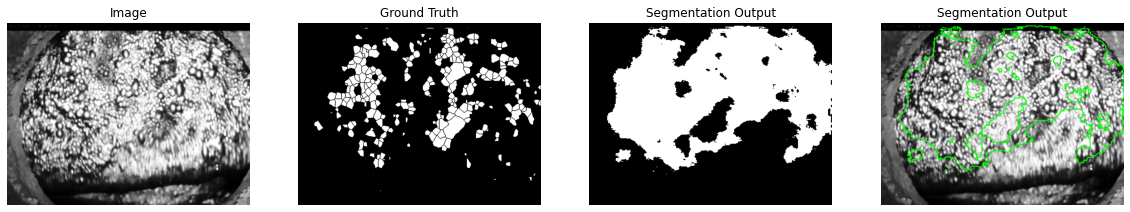

In [58]:
import time
import random

lr = 1e-6
loss = 'MSE'
f = random.choice(os.listdir(path_to_dataset+'/image'))
files_list = os.listdir(path_to_dataset+'/image')
files_list = [f]
for model_name in ready:
  print(model_name)
  iou_summ = 0
  iou_min = 1
  iou_min_num = 0
  iou_max = 0
  iou_max_num = 0
  time_avg = 0
  for f in files_list:
    # training
    # print(f)
    filename = path_to_exp + f'/{model_name}_weights.pt'
    # try:
    model = torch.load(filename)
    num = int(f.split('.')[0])
    model.eval()
    source, resized_img, target, resized_target = prepare_data(num)
    time_1 = time.time()
    pred_raw, pred = compute_result(model, model_name, resized_img, th=ths[model_name])
    # print("time", model_name, time.time() - time_1)
    # print("iou", iou(pred, resized_target))
    curr_iou = iou(pred, resized_target)
    iou_summ += curr_iou 
    time_avg += (time.time() - time_1)
    if curr_iou < iou_min:
      iou_min = curr_iou
      iou_min_num = num
    if curr_iou > iou_max:
      iou_max = curr_iou
      iou_max_num = num

    contours = source.copy()
    contours = cv2.cvtColor(contours, cv2.COLOR_GRAY2RGB)
    pred = cv2.resize(pred, (contours.shape[1], contours.shape[0]))
    cnts, hierarchy = cv2.findContours(pred, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(contours, cnts, -1, (0, 255, 0), 2)

    visualize(cv2.cvtColor(source, cv2.COLOR_BGR2RGB),  cv2.resize(target, (contours.shape[1], contours.shape[0])), pred_raw, pred, contours)

  list_len = len(files_list)
  print("iou avg", iou_summ/list_len)
  print("time avg", time_avg/list_len)
  print("iou min", iou_min, iou_min_num)
  print("iou max", iou_max, iou_max_num)
  # except Exception as e:
  #   print(e)

In [54]:
# import os
# import random
# for _ in range(10):
#   files = os.listdir("/content/drive/MyDrive/datasets/masks/image")
#   f = random.choice(files)
#   print(f)
#   os.rename(f"/content/drive/MyDrive/datasets/masks/image/{f}", f"/content/drive/MyDrive/datasets/masks/test/image/{f}")
#   os.rename(f"/content/drive/MyDrive/datasets/masks/label/{f}", f"/content/drive/MyDrive/datasets/masks/test/label/{f}")

In [55]:
model = torch.load('/content/drive/MyDrive/Froth/froth_dataset/exp/unet_weights.pt')
model_name = "unet"
model.eval()
source, resized_img, target, resized_target = prepare_data(5)
time_1 = time.time()
pred_raw, pred = compute_result(model, model_name, resized_img, th=ths[model_name])
visualize(source, target, pred_raw, pred)
print(model_name, time.time() - time_1)

FileNotFoundError: ignored

# ToDo

## Networks
###Segmentation

#### DeepLab based
* DeepLabv3 v (29.10)
* DeepLabV3+ 
* PointRend
* Detectron2


#### Unet-like
* Unet   (29.10) v 
* Unet++  (30.10) v
* Tiny-UNET  (30.10) 
* PSPnet (30.10) v

#### Transformers 
* HRNet OCR

#### Others
* FPN  v
* MA-Net v
* ResT
* Mask-RCNN


* PointNet
* FCN

* SFNet (ECCV 2020)
* SegFormer (ArXiv 2021)
* FaPN (ICCV 2021)
* CondNet (IEEE SPL 2021)
### Detection
*   YOLO
*   SSD
* RCNN

## Losses
* MSE +
* Cross Entropy Loss
* Focal Loss
* Dice Loss

## OF 
* FlowNet


